## NBA Position Predictor Project

### Created 16 November 2021

## Initial Exploratory Data Analysis

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [30]:
def get_data(year):
    """Get the data for the season corresponding to the specified year"""
    link = f'https://www.nbastuffer.com/{year}-{year+1}-nba-player-stats/'  # data source
    df = pd.read_html(link)[0]
    df = clean_data(df, year)
    return df

def clean_data(d, year):
    """Clean the specified dataframe for the specified year"""
    d['Year'] = year  # initial year 
    
    if year in [2019, 2020, 2021]:
        d = d.rename(columns={"TO%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions":"TO%"})
    elif year == 2018:
        d = d.rename(columns={"Tor%Turnover RateA metric that estimates the number of turnovers a player commits per 100 possessions":"TO%"})
    else:  # year == 2017:
        d = d.rename(columns={"TOrTurnover RateA metric that estimates the number of turnovers a player commits per 100 possessions":"TO%"})
    return d

data = [get_data(i) for i in range(2017, 2022)]  # all data from 2017-2018 to 2021-2022 seasons

In [31]:
# add all data from 2017-2018 to 2021-2022 seasons into one dataframe
print([d.shape for d in data])
stats_df = pd.concat(data, ignore_index=True)
stats_df

[(209, 30), (212, 30), (216, 30), (239, 30), (553, 30)]


,RANK,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor,"USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor",TO%,...,TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.,APGAssistsAssists per game.,AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court,SPGStealsSteals per game.,BPGBlocksBlocks per game.,TOPGTurnoversTurnovers per game.,"VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10",ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.,DRTGDefensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court.,Year
0,NaN,Aaron Brooks,Min,PG,33.00,2,1.4,2.8,63.7,0.000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,NaN,NaN,2017
1,NaN,Aaron Jackson,Hou,F,31.00,7,2.4,5.1,17.8,0.291,...,13.1,0.3,17.2,0.00,0.00,0.29,8.4,NaN,NaN,2017
2,NaN,Abdel Nader,Bos,SF,24.00,11,3.0,6.3,25.5,0.107,...,5.0,0.3,14.3,0.09,0.09,0.18,6.2,NaN,NaN,2017
3,NaN,Al Horford,Bos,C,31.00,19,35.7,74.4,17.8,0.119,...,12.8,3.3,14.9,1.00,1.16,1.68,8.5,112.7,102.7,2017
4,NaN,Alec Burks,Uta,SG,26.00,9,13.4,27.9,28.9,0.103,...,11.2,1.9,25.9,0.44,0.11,0.89,10.7,110.0,101.1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,NaN,Ivica Zubac,Lac,C,24.78,34,24.9,51.8,14.7,16.200,...,17.1,1.1,6.6,0.56,1.18,1.35,7.2,131.7,97.8,2021
1425,NaN,Jordan Goodwin,Was,G,23.18,1,2.9,6.0,30.8,0.000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,NaN,NaN,2021
1426,NaN,Alize Johnson,Was,F,25.69,1,9.5,19.8,39.7,35.500,...,46.0,0.0,0.0,0.00,0.00,3.00,0.0,78.0,112.0,2021
1427,NaN,Craig Sword,Was,G,27.95,1,14.3,29.8,15.6,20.000,...,0.0,1.0,11.5,3.00,0.00,1.00,0.0,114.6,68.7,2021


In [32]:
# clean up the verbose column names 
stats_df = stats_df.rename(columns={
    "FULL NAME":"NAME",
    "MIN%Minutes PercentagePercentage of team minutes used by a player while he was on the floor": "MIN%", 
    "USG%Usage RateUsage rate, a.k.a., usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor": "USG%",
    "eFG%Effective Shooting PercentageWith eFG%, three-point shots made are worth 50% more than two-point shots made. eFG% Formula=(FGM+ (0.5 x 3PM))/FGA":"eFG%",
    "TS%True Shooting PercentageTrue shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.":"TS%",
    "PPGPointsPoints per game.":"PPG",
    "RPGReboundsRebounds per game.":"RPG",
    "TRB%Total Rebound PercentageTotal rebound percentage is estimated percentage of available rebounds grabbed by the player while the player is on the court.":"TRB%",
    "APGAssistsAssists per game.":"APG",
    "AST%Assist PercentageAssist percentage is an estimated percentage of teammate field goals a player assisted while the player is on the court":"AST%",
    "SPGStealsSteals per game.":"SPG",
    "BPGBlocksBlocks per game.":"BPG",
    "TOPGTurnoversTurnovers per game.":"TOPG",
    "VIVersatility IndexVersatility index is a metric that measures a player’s ability to produce in points, assists, and rebounds. The average player will score around a five on the index, while top players score above 10":"VI",
    "ORTGOffensive RatingIndividual offensive rating is the number of points produced by a player per 100 total individual possessions.":"ORTG",
    "DRTGDefensive RatingIndividual defensive rating estimates how many points the player allowed per 100 possessions he individually faced while staying on the court.":"DRTG"                  
    })

In [33]:
stats_df

,RANK,NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,...,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year
0,NaN,Aaron Brooks,Min,PG,33.00,2,1.4,2.8,63.7,0.000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,NaN,NaN,2017
1,NaN,Aaron Jackson,Hou,F,31.00,7,2.4,5.1,17.8,0.291,...,13.1,0.3,17.2,0.00,0.00,0.29,8.4,NaN,NaN,2017
2,NaN,Abdel Nader,Bos,SF,24.00,11,3.0,6.3,25.5,0.107,...,5.0,0.3,14.3,0.09,0.09,0.18,6.2,NaN,NaN,2017
3,NaN,Al Horford,Bos,C,31.00,19,35.7,74.4,17.8,0.119,...,12.8,3.3,14.9,1.00,1.16,1.68,8.5,112.7,102.7,2017
4,NaN,Alec Burks,Uta,SG,26.00,9,13.4,27.9,28.9,0.103,...,11.2,1.9,25.9,0.44,0.11,0.89,10.7,110.0,101.1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,NaN,Ivica Zubac,Lac,C,24.78,34,24.9,51.8,14.7,16.200,...,17.1,1.1,6.6,0.56,1.18,1.35,7.2,131.7,97.8,2021
1425,NaN,Jordan Goodwin,Was,G,23.18,1,2.9,6.0,30.8,0.000,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,NaN,NaN,2021
1426,NaN,Alize Johnson,Was,F,25.69,1,9.5,19.8,39.7,35.500,...,46.0,0.0,0.0,0.00,0.00,3.00,0.0,78.0,112.0,2021
1427,NaN,Craig Sword,Was,G,27.95,1,14.3,29.8,15.6,20.000,...,0.0,1.0,11.5,3.00,0.00,1.00,0.0,114.6,68.7,2021


In [34]:
stats_df.describe()

,RANK,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,...,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year
count,0.0,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1390.000000,1429.000000,1429.000000,1429.000000,...,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1262.000000,1267.000000,1429.000000
mean,NaN,26.898964,12.541638,19.117915,39.821204,18.160182,10.107719,25.438069,0.621997,61.600420,...,10.086564,1.755773,12.495171,0.577677,0.374577,1.015626,5.877467,107.494691,103.464009,2019.500350
std,NaN,4.278667,9.982855,11.575115,24.121730,7.555648,9.235374,36.923114,0.327792,80.999468,...,6.318447,1.959332,11.226739,0.509454,0.453100,0.972988,3.302297,21.861661,6.598586,1.483157
min,NaN,19.000000,1.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.100000,2017.000000
25%,NaN,23.490000,4.000000,8.700000,18.000000,13.500000,2.525000,2.000000,0.500000,6.000000,...,6.200000,0.500000,5.300000,0.180000,0.000000,0.330000,4.400000,97.900000,99.900000,2018.000000
50%,NaN,26.420000,9.000000,18.200000,37.800000,17.400000,10.000000,11.000000,0.741000,30.000000,...,9.000000,1.100000,9.300000,0.500000,0.250000,0.750000,6.200000,108.800000,103.800000,2020.000000
75%,NaN,29.800000,21.000000,29.500000,61.400000,22.200000,14.300000,33.000000,0.846000,82.000000,...,13.100000,2.400000,17.500000,0.890000,0.520000,1.420000,7.900000,118.100000,107.650000,2021.000000
max,NaN,41.550000,36.000000,41.900000,87.300000,63.700000,100.000000,288.000000,1.000000,475.000000,...,68.200000,12.200000,81.900000,3.000000,4.000000,5.170000,20.200000,280.100000,123.500000,2021.000000


In [35]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RANK    0 non-null      float64
 1   NAME    1429 non-null   object 
 2   TEAM    1429 non-null   object 
 3   POS     1429 non-null   object 
 4   AGE     1429 non-null   float64
 5   GP      1429 non-null   int64  
 6   MPG     1429 non-null   float64
 7   MIN%    1429 non-null   float64
 8   USG%    1429 non-null   float64
 9   TO%     1390 non-null   float64
 10  FTA     1429 non-null   int64  
 11  FT%     1429 non-null   float64
 12  2PA     1429 non-null   int64  
 13  2P%     1429 non-null   float64
 14  3PA     1429 non-null   int64  
 15  3P%     1429 non-null   float64
 16  eFG%    1384 non-null   float64
 17  TS%     1388 non-null   float64
 18  PPG     1429 non-null   float64
 19  RPG     1429 non-null   float64
 20  TRB%    1429 non-null   float64
 21  APG     1429 non-null   float64
 22  

In [36]:
print(stats_df.isnull().sum(), '\n')
print(stats_df.isnull().sum(axis=1).sort_values(ascending=False))

RANK    1429
NAME       0
TEAM       0
POS        0
AGE        0
GP         0
MPG        0
MIN%       0
USG%       0
TO%       39
FTA        0
FT%        0
2PA        0
2P%        0
3PA        0
3P%        0
eFG%      45
TS%       41
PPG        0
RPG        0
TRB%       0
APG        0
AST%       0
SPG        0
BPG        0
TOPG       0
VI         0
ORTG     167
DRTG     162
Year       0
dtype: int64 

859     6
31      6
1165    6
410     6
24      6
       ..
508     1
507     1
506     1
505     1
1428    1
Length: 1429, dtype: int64


In [37]:
stats2_df = stats_df[stats_df.isnull().sum(axis=1) < 2] # get rid of rows w/o sufficient data
stats2_df

,RANK,NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,...,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year
3,NaN,Al Horford,Bos,C,31.00,19,35.7,74.4,17.8,0.119,...,12.8,3.3,14.9,1.00,1.16,1.68,8.5,112.7,102.7,2017
4,NaN,Alec Burks,Uta,SG,26.00,9,13.4,27.9,28.9,0.103,...,11.2,1.9,25.9,0.44,0.11,0.89,10.7,110.0,101.1,2017
5,NaN,Alex Abrines,Okc,SG,24.00,6,18.3,38.2,8.5,0.046,...,7.5,0.3,2.4,0.83,0.33,0.17,3.2,119.8,102.0,2017
6,NaN,Al-Farouq Aminu,Por,SF,27.00,4,32.7,68.2,19.7,0.102,...,15.0,1.3,6.2,1.00,0.50,1.50,7.2,126.2,112.7,2017
7,NaN,Amir Johnson,Phi,PF,30.00,8,11.7,24.4,11.9,0.115,...,13.2,1.1,13.3,0.25,0.13,0.38,7.5,122.7,100.4,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,NaN,Cody Zeller,Por,F-C,29.23,24,13.3,27.7,15.6,15.000,...,19.2,0.8,9.3,0.29,0.25,0.71,8.0,129.4,98.6,2021
1424,NaN,Ivica Zubac,Lac,C,24.78,34,24.9,51.8,14.7,16.200,...,17.1,1.1,6.6,0.56,1.18,1.35,7.2,131.7,97.8,2021
1426,NaN,Alize Johnson,Was,F,25.69,1,9.5,19.8,39.7,35.500,...,46.0,0.0,0.0,0.00,0.00,3.00,0.0,78.0,112.0,2021
1427,NaN,Craig Sword,Was,G,27.95,1,14.3,29.8,15.6,20.000,...,0.0,1.0,11.5,3.00,0.00,1.00,0.0,114.6,68.7,2021


In [38]:
#divide the data into the input 'X' and the labels 'y'
X        = stats2_df[[
 'MIN%',
 'USG%',
 'TO%',
 'FTA',
 'FT%',
 '2PA',
 '2P%',
 '3PA',
 '3P%',
 'eFG%',
 'TS%',
 'PPG',
 'RPG',
 'TRB%',
 'APG',
 'AST%',
 'SPG',
 'BPG',
 'TOPG',
 'VI',
 'ORTG',
 'DRTG']] #the observations
y        = stats2_df['POS'] #the label

In [39]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=6, stratify = y 
                                        #TODO: enter the appropriate values to partition the data, 
                                        #and ensure your results are reproducible
                                        #and obtain stratified samples
                                        ) 

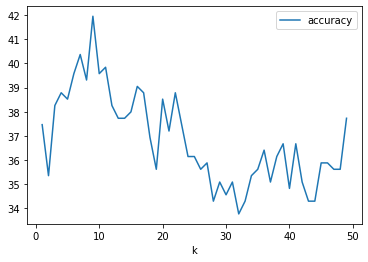

In [42]:
k = []
accuracy = []
#build the k-nn model, experiment with different values of k and plot the results
for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    k.append(i)
    accuracy.append(knn.score(X_test, y_test)*100)
    #print(knn.predict(X_test))
    #print('The accuracy of the model is {}'.format(knn.score(X_test, y_test)))
    
    
acc = pd.DataFrame({'k': k, 'accuracy': accuracy})
lines = acc.plot.line(x = 'k')
    

In [43]:
knn = KNeighborsClassifier(n_neighbors=8) 
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.29      0.34      0.32        35
         C-F       0.29      0.15      0.20        13
           F       0.36      0.59      0.44        94
         F-C       0.22      0.10      0.13        21
         F-G       0.00      0.00      0.00        14
           G       0.49      0.60      0.54       124
         G-F       0.43      0.10      0.16        31
          PF       0.00      0.00      0.00        11
          PG       0.00      0.00      0.00        13
          SF       0.00      0.00      0.00        11
          SG       0.00      0.00      0.00        12

    accuracy                           0.39       379
   macro avg       0.19      0.17      0.16       379
weighted avg       0.33      0.39      0.34       379

